![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de árboles de decisión y métodos de ensamblaje

En este taller podrá poner en práctica los sus conocimientos sobre construcción e implementación de árboles de decisión y métodos de ensamblajes. El taller está constituido por 9 puntos, 5 relacionados con árboles de decisión (parte A) y 4 con métodos de ensamblaje (parte B).

## Parte A - Árboles de decisión

En esta parte del taller se usará el conjunto de datos de Capital Bikeshare de Kaggle, donde cada observación representa el alquiler de una bicicleta durante una hora y día determinado. Para más detalles puede visitar los siguientes enlaces: [datos](https://github.com/justmarkham/DAT8/blob/master/data/bikeshare.csv), [dicccionario de datos](https://www.kaggle.com/c/bike-sharing-demand/data).

### Datos prestamo de bicicletas

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importación de librerías
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, export_graphviz

In [3]:
# Lectura de la información de archivo .csv
bikes = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/bikeshare.csv', index_col='datetime', parse_dates=True)
# Renombrar variable "count" a "total"
bikes.rename(columns={'count':'total'}, inplace=True)
# Crear la hora como una variable 
bikes['hour'] = bikes.index.hour
# Visualización
bikes.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total,hour
datetime,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,3
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,4


### Punto 1 - Análisis descriptivo

Ejecute las celdas 1.1 y 1.2. A partir de los resultados realice un análisis descriptivo sobre las variables hour y workingday, escriba sus inferencias sobre los datos. Para complementar su análisis puede usar métricas como máximo, mínimo, percentiles entre otros.

In [4]:
# Celda 1.1
bikes.groupby('workingday').total.mean()

workingday
0    188.506621
1    193.011873
Name: total, dtype: float64

In [5]:
# Celda 1.2
bikes.groupby('hour').total.mean()

hour
0      55.138462
1      33.859031
2      22.899554
3      11.757506
4       6.407240
5      19.767699
6      76.259341
7     213.116484
8     362.769231
9     221.780220
10    175.092308
11    210.674725
12    256.508772
13    257.787281
14    243.442982
15    254.298246
16    316.372807
17    468.765351
18    430.859649
19    315.278509
20    228.517544
21    173.370614
22    133.576754
23     89.508772
Name: total, dtype: float64

In [6]:
print('Estadisticas descriptivas por columna')
print('--------------------------------------')
print(bikes[['workingday','hour']].describe(include = 'all'))

print('--------------------------------------------')
print('Cantidad de datos null or nan por columna:')
percent_missing = bikes[['workingday','hour']].isna().sum() * 100 / len(bikes[['workingday','hour']])
missing_value_df = pd.DataFrame({'#_faltantes': bikes[['workingday','hour']].isna().sum(),
                                 '%_faltantes': percent_missing})
print(missing_value_df)

print('--------------------------------------------')
print('Numero de registros por workingday')
print(bikes.groupby('workingday').total.count())

print('--------------------------------------------')
print('Promedio por hora:')
no_working_day = (bikes.loc[bikes['workingday'] == 0]).groupby('hour')
working_day = (bikes.loc[bikes['workingday'] == 1]).groupby('hour')
df_wd = pd.DataFrame({'workingday = 0': no_working_day.total.mean(),
                      'workingday = 1': working_day.total.mean()})
print(df_wd)



Estadisticas descriptivas por columna
--------------------------------------
         workingday          hour
count  10886.000000  10886.000000
mean       0.680875     11.541613
std        0.466159      6.915838
min        0.000000      0.000000
25%        0.000000      6.000000
50%        1.000000     12.000000
75%        1.000000     18.000000
max        1.000000     23.000000
--------------------------------------------
Cantidad de datos null or nan por columna:
            #_faltantes  %_faltantes
workingday            0          0.0
hour                  0          0.0
--------------------------------------------
Numero de registros por workingday
workingday
0    3474
1    7412
Name: total, dtype: int64
--------------------------------------------
Promedio por hora:
      workingday = 0  workingday = 1
hour                                
0          94.489655       36.732258
1          71.910345       16.003236
2          53.748252        8.436066
3          25.534722        4.89

> #### Inferencias
> * El set de datos proporciandos contiene 10886 registros
> * Ninguna de las variables de predictoras hour y workingday presentan valores nulos o vacios
> * La variable workingday es una variable categorica bivariada, dónde 0 corresponde a los días que son fin de semana o días festivos y 1 para el caso contrario
> * El número total de registros es mayor para workingday  = 1 pero sólo un poco, esto de acuerdo con la media que esta posicionada en 0.680875

### Punto 2 - Análisis de gráficos

Primero ejecute la celda 2.1 y asegúrese de comprender el código y el resultado. Luego, en cada una de celdas 2.2 y 2.3 escriba un código que genere una gráfica de las rentas promedio por hora cuando la variable "workingday" es igual a 0 e igual a 1, respectivamente. Analice y escriba sus hallazgos.

<AxesSubplot:xlabel='hour'>

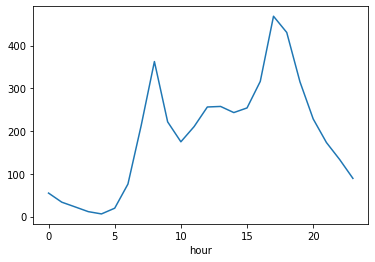

In [7]:
# Celda 2.1 - rentas promedio para cada valor de la variable "hour"
bikes.groupby('hour').total.mean().plot()

Rentas promedio por hora cuando la variable "workingday" = 0


<AxesSubplot:xlabel='hour'>

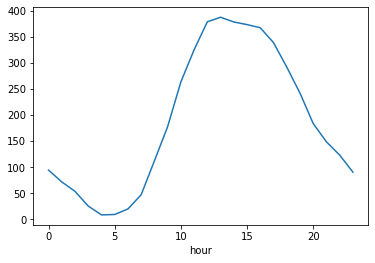

In [8]:
# Celda 2.2 - "workingday"=0 escriba su código y hallazgos 
print('Rentas promedio por hora cuando la variable "workingday" = 0')
(bikes.loc[bikes['workingday'] == 0]).groupby('hour').total.mean().plot()

> #### Celda 2.2 - Hallazgos
La gráfica muestra 3474 registros que coninciden con la condición workingday = 0. Como se puede observar, cuando es fin de semana o día de descanso (holiday), la renta de biclicletas incrementa durante el día, alcanzando su máximo punto a las 13:00 hrs con un promedio menor a 400 y después disminuye de manera gradual

Rentas promedio por hora cuando la variable "workingday" = 1


<AxesSubplot:xlabel='hour'>

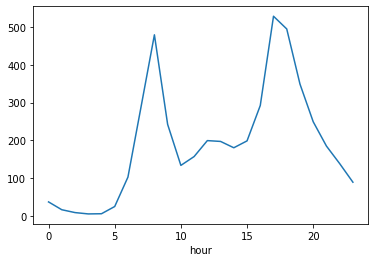

In [9]:
# Celda 2.3 - "workingday"=1 escriba su código y hallazgos 
print('Rentas promedio por hora cuando la variable "workingday" = 1')
(bikes.loc[bikes['workingday'] == 1]).groupby('hour').total.mean().plot()

> #### Celda 2.3 - Hallazgos
La gráfica muestra 7412 registros que coninciden con la condición workingday = 1. Como se puede observar, cuando es un workingday, la renta de biclicletas tiene dos picos altos, uno a las 8:00 hrs y otro a las 17:00 hrs, ventana de tiempo que coincide con la jornada laboral en Washington, D.C (ciudad donde fueron recopilados los datos); tal y como se indica en el sitio oficial [Hours of duty and work schedules](https://www.commerce.gov/hr/practitioners/leave-policies/hours-of-duty-and-work-schedules#:~:text=The%20basic%20work%20week%20for,lunch%20period%20of%2030%20minutes.) del gobierno de los Estados Unidos


### Punto 3 - Regresión lineal
En la celda 3 ajuste un modelo de regresión lineal a todo el conjunto de datos, utilizando "total" como variable de respuesta y "hour" y "workingday" como las únicas variables predictoras. Luego, imprima los coeficientes e interprételos. ¿Cuáles son las limitaciones de la regresión lineal en este caso?

In [10]:
# Celda 3
from sklearn.model_selection import train_test_split
from sklearn import metrics

X = bikes[['hour','workingday']]
y = bikes[['total']]

reg = LinearRegression().fit(X, y)
print('Score')
print(reg.score(X, y))
print('Coeficientes')
print(reg.coef_)
print('Intercepto')
print(reg.intercept_)


#Para comparación 
XTrain, XTest, yTrain, yTest = train_test_split(X, y, test_size=0.33, random_state=0)
reg = LinearRegression().fit(XTrain, yTrain)
yPred = reg.predict(XTest)
print("------------------------------------------")
print("Métrica de desempeño R2: " + str(metrics.r2_score(yTest, yPred)))

Score
0.16059115011434855
Coeficientes
[[10.49206282  4.07248627]]
Intercepto
[67.70595026]
------------------------------------------
Métrica de desempeño R2: 0.15357074523449832


> #### ¿Cuáles son las limitaciones de la regresión lineal en este caso?
> Gracias a los coeficientes se puede interpretar que por cada unidad de cambio en la hora el total aumenta el 10.49% y el 4.07% respecto al workingday.
> Nuestra ecuación sería algo como total = 67.70 + 10.49 hour + 4.07 workingday, por lo cuál podríamos decir que la hora es el predictor más relevante. 

> La implementación del modelo de regresión lineal nos limita principalmente porque nuestros datos NO TIENDEN a un línea, esto se puede ver claramente en las gáficas que generamos anteriormente, tenemos altas y bajas en los valores y de acuerdo a nuestra ecuación siempre se van a predecir valores crecientes y esto no es cierto, a tráves de las horas los valores aumentan o disminuyen

### Punto 4 - Árbol de decisión manual
En la celda 4 cree un árbol de decisiones para pronosticar la variable "total" iterando **manualmente** sobre las variables "hour" y  "workingday". El árbol debe tener al menos 6 nodos finales.

In [ ]:
# Celda 4

# Definición de parámetros y criterios de parada
max_depth = None
num_pct = 10
max_features = None
min_gain=0.001

### Punto 5 - Árbol de decisión con librería
En la celda 5 entrene un árbol de decisiones con la **librería sklearn**, usando las variables predictoras "hour" y "workingday" y calibre los parámetros que considere conveniente para obtener un mejor desempeño. Comente el desempeño del modelo con alguna métrica de desempeño de modelos de regresión y compare desempeño con el modelo del punto 3.

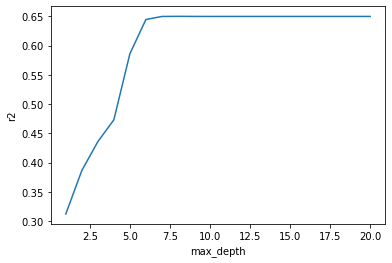

(0.6501337581022684, 8)
Métrica de desempeño R2: 0.6504671083410165


In [11]:
# Celda 5
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

XTrain, XTest, yTrain, yTest = train_test_split(X, y, test_size=0.33, random_state=0)

max_depth_range = range(1, 21)
r2_scores = []

for depth in max_depth_range:
    clf = DecisionTreeRegressor(max_depth=depth, random_state=1)
    r2_scores.append(cross_val_score(clf, XTrain, yTrain, cv=10, scoring='r2').mean())
    
plt.plot(max_depth_range, r2_scores)
plt.xlabel('max_depth')
plt.ylabel('r2')
plt.show()

# Mejor R2 (desempeño del modelo) y su correspondiente max_depth
best_num_tree = sorted(zip(r2_scores, max_depth_range))[::-1][0][1]
print(sorted(zip(r2_scores, max_depth_range))[::-1][0])

#Para la comparación de desempeño
from sklearn.metrics import r2_score

# max_depth=8 fue el mejor, se ajusta un árbol usando este valor 
clf = DecisionTreeRegressor(max_depth=best_num_tree, random_state=1)
clf.fit(XTrain, yTrain)
yPred = clf.predict(XTest)
print("Métrica de desempeño R2: " + str(r2_score(yTest, yPred)))

> #### Desempeño del modelo y comparación con el modelo del punto 3.
> El mejor max_depth fue 8, es aquí donde se obtiene el mejor R2 para nuestro modelo.
> El R2 del árbol de decisión muestra un mejor desempeño con un valor mayor en comparación del modelo del punto 3, de hecho el modelo del punto 3 muestra un R2 del 15%, lo cuál quiere decir que el modelo de Regresión lineal explica muy poco la variabilidad de los datos

## Parte B - Métodos de ensamblajes
En esta parte del taller se usará el conjunto de datos de Popularidad de Noticias Online. El objetivo es predecir si la notica es popular o no, la populridad esta dada por la cantidad de reacciones en redes sociales. Para más detalles puede visitar el sigueinte enlace: [datos](https://archive.ics.uci.edu/ml/datasets/online+news+popularity).

### Datos popularidad de noticias

In [12]:
# Lectura de la información de archivo .csv
df = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/mashable.csv', index_col=0)
df.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,Popular
0,http://mashable.com/2014/12/10/cia-torture-rep...,28.0,9.0,188.0,0.732620,1.0,0.844262,5.0,1.0,1.0,...,0.200000,0.80,-0.487500,-0.60,-0.250000,0.9,0.8,0.4,0.8,1
1,http://mashable.com/2013/10/18/bitlock-kicksta...,447.0,7.0,297.0,0.653199,1.0,0.815789,9.0,4.0,1.0,...,0.160000,0.50,-0.135340,-0.40,-0.050000,0.1,-0.1,0.4,0.1,0
2,http://mashable.com/2013/07/24/google-glass-po...,533.0,11.0,181.0,0.660377,1.0,0.775701,4.0,3.0,1.0,...,0.136364,1.00,0.000000,0.00,0.000000,0.3,1.0,0.2,1.0,0
3,http://mashable.com/2013/11/21/these-are-the-m...,413.0,12.0,781.0,0.497409,1.0,0.677350,10.0,3.0,1.0,...,0.100000,1.00,-0.195701,-0.40,-0.071429,0.0,0.0,0.5,0.0,0
4,http://mashable.com/2014/02/11/parking-ticket-...,331.0,8.0,177.0,0.685714,1.0,0.830357,3.0,2.0,1.0,...,0.100000,0.55,-0.175000,-0.25,-0.100000,0.0,0.0,0.5,0.0,0


In [13]:
# Definición variable de interes y variables predictoras
X = df.drop(['url', 'Popular'], axis=1)
y = df['Popular']
y.mean()

0.5

In [14]:
# División de la muestra en set de entrenamiento y prueba
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

### Punto 6 - Árbol de decisión y regresión logística
En la celda 6 construya un árbol de decisión y una regresión logística. Para el árbol calibre al menos un parámetro y evalúe el desempeño de cada modelo usando las métricas de Accuracy y F1-Score.

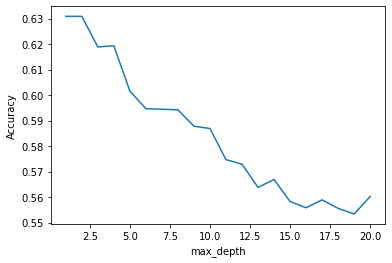

--------------------------------------------
Árbol de decisión
Accuracy: 0.6453333333333333
F1: 0.6448598130841121
--------------------------------------------
Regresión Logistica
Accuracy: 0.6146666666666667
F1: 0.6110363391655451


In [15]:
# Celda 6

#Selección del mejor Árbol de decisión 
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

max_depth_range = range(1, 21)
accuracy_scores  = []

for depth in max_depth_range:
    clf = DecisionTreeClassifier(max_depth=depth, random_state=1)
    accuracy_scores.append(cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy').mean())
    
plt.plot(max_depth_range, accuracy_scores)
plt.xlabel('max_depth')
plt.ylabel('Accuracy')
plt.show()

best_num_tree = sorted(zip(accuracy_scores, max_depth_range))[::-1][0][1]

#Métricas
arbol = DecisionTreeClassifier(max_depth=best_num_tree, random_state=1)
arbol.fit(X_train, y_train)
yPredArbol = arbol.predict(X_test)

print("--------------------------------------------")
print("Árbol de decisión")
print("Accuracy: " + str(metrics.accuracy_score(y_test, yPredArbol)))
print("F1: " + str(metrics.f1_score(y_test, yPredArbol)))

reg = LogisticRegression(random_state=0).fit(X_train, y_train)
yPredReg = reg.predict(X_test)

print("--------------------------------------------")
print("Regresión Logistica")
print("Accuracy: " + str(metrics.accuracy_score(y_test, yPredReg)))
print("F1: " + str(metrics.f1_score(y_test, yPredReg)))

> #### Comparación de modelos
> Para el árbol se utilizo una profundidad de 2 dado que arrojo el mejor Accuracy. Comparando estos modelos con las dos metricas podemos decir que el árbol de decisión funciona mejor que la regresión logistica

### Punto 7 - Votación Mayoritaria
En la celda 7 elabore un esamble con la metodología de **Votación mayoritaria** compuesto por 300 muestras bagged para cada uno de los siguientes escenarios:

-100 árboles de decisión donde max_depth = None\
-100 árboles de decisión donde max_depth = 2\
-100 regresiones logísticas

Evalúe los modelos utilizando las métricas de Accuracy y F1-Score.

In [16]:
# Celda 7
from sklearn.ensemble import BaggingClassifier

num_estimadores = 100

# 100 árboles de decisión donde max_depth = None
mdNone = BaggingClassifier(base_estimator = DecisionTreeClassifier(max_depth=None), n_estimators=num_estimadores, 
                           bootstrap =True, random_state=42, n_jobs=-1, oob_score=True)
# 100 árboles de decisión donde max_depth = 2
md2 = BaggingClassifier(base_estimator = DecisionTreeClassifier(max_depth=2), n_estimators=num_estimadores, 
                           bootstrap =True, random_state=42, n_jobs=-1, oob_score=True)
# 100 regresiones logísticas
rl = BaggingClassifier(base_estimator=LogisticRegression(), n_estimators=num_estimadores, 
                           bootstrap=True, random_state=42, n_jobs=-1, oob_score=True)


# Predicción y desempeño al hacer votación mayoritaria
print("-------------------------------------")
print("Desempeño al hacer votación mayoritaria")

mdNone.fit(X_train, y_train)
yPredmdNone = mdNone.predict(X_test)
print("--------------------------------------------")
print("100 árboles de decisión donde max_depth = None")
print("Accuracy: " + str(metrics.accuracy_score(yPredmdNone, y_test)))
print("F1: " + str(metrics.f1_score(yPredmdNone, y_test)))

md2.fit(X_train, y_train)
yPredmd2 = md2.predict(X_test)
print("--------------------------------------------")
print("100 árboles de decisión donde max_depth = 2")
print("Accuracy: " + str(metrics.accuracy_score(yPredmd2, y_test)))
print("F1: " + str(metrics.f1_score(yPredmd2, y_test)))

rl.fit(X_train, y_train)
yPredmrl = rl.predict(X_test)
print("--------------------------------------------")
print("100 regresiones logísticas")
print("Accuracy: " + str(metrics.accuracy_score(yPredmrl, y_test)))
print("F1: " + str(metrics.f1_score(yPredmrl, y_test)))



-------------------------------------
Desempeño al hacer votación mayoritaria
--------------------------------------------
100 árboles de decisión donde max_depth = None
Accuracy: 0.64
F1: 0.642384105960265
--------------------------------------------
100 árboles de decisión donde max_depth = 2
Accuracy: 0.6446666666666667
F1: 0.6439545758183033
--------------------------------------------
100 regresiones logísticas
Accuracy: 0.6173333333333333
F1: 0.6126855600539811


### Punto 8 - Votación Ponderada
En la celda 8 elabore un ensamble con la metodología de **Votación ponderada** compuesto por 300 muestras bagged para los mismos tres escenarios del punto 7. Evalúe los modelos utilizando las métricas de Accuracy y F1-Score

In [17]:
# Celda 8

# 100 árboles de decisión donde max_depth = None
errors_none = np.zeros(mdNone.n_estimators)
y_pred_all_none = np.zeros((X_test.shape[0], mdNone.n_estimators))

# 100 árboles de decisión donde max_depth = 2
errors_2 = np.zeros(md2.n_estimators)
y_pred_all_2 = np.zeros((X_test.shape[0], md2.n_estimators))

# 100 regresiones logísticas
errors_rl = np.zeros(rl.n_estimators)
y_pred_all_rl = np.zeros((X_test.shape[0], rl.n_estimators))

for i in range(num_estimadores):
    
    #100 árboles de decisión donde max_depth = None
    oob_sample = ~mdNone.estimators_samples_[i]
    y_pred_ = mdNone.estimators_[i].predict(X_train.values[oob_sample])
    errors_none[i] = metrics.accuracy_score(y_pred_, y_train.values[oob_sample])
    y_pred_all_none[:, i] = mdNone.estimators_[i].predict(X_test)
    
    # 100 árboles de decisión donde max_depth = 2
    oob_sample = ~md2.estimators_samples_[i]
    y_pred_ = md2.estimators_[i].predict(X_train.values[oob_sample])
    errors_2[i] = metrics.accuracy_score(y_pred_, y_train.values[oob_sample])
    y_pred_all_2[:, i] = md2.estimators_[i].predict(X_test)
    
    # 100 regresiones logísticas
    oob_sample = ~rl.estimators_samples_[i]
    y_pred_ = rl.estimators_[i].predict(X_train.values[oob_sample])
    errors_rl[i] = metrics.accuracy_score(y_pred_, y_train.values[oob_sample])
    y_pred_all_rl[:, i] = rl.estimators_[i].predict(X_test)

# Desempeño al hacer votación ponderada
print("-------------------------------------")
print("Desempeño al hacer votación ponderada")

#100 árboles de decisión donde max_depth = None
alpha = (1 - errors_none) / (1 - errors_none).sum()
yPredNone = (np.sum(y_pred_all_none * alpha, axis=1) >= 0.5).astype(np.int)
print("--------------------------------------------")
print("100 árboles de decisión donde max_depth = None")
print("Accuracy: " + str(metrics.accuracy_score(yPredNone, y_test)))
print("F1: " + str(metrics.f1_score(yPredNone, y_test)))

# 100 árboles de decisión donde max_depth = 2
alpha = (1 - errors_2) / (1 - errors_2).sum()
yPred2 = (np.sum(y_pred_all_2 * alpha, axis=1) >= 0.5).astype(np.int)
print("--------------------------------------------")
print("100 árboles de decisión donde max_depth = 2")
print("Accuracy: " + str(metrics.accuracy_score(yPred2, y_test)))
print("F1: " + str(metrics.f1_score(yPred2, y_test)))

# 100 regresiones logísticas
alpha = (1 - errors_rl) / (1 - errors_rl).sum()
yPredrl = (np.sum(y_pred_all_rl * alpha, axis=1) >= 0.5).astype(np.int)
print("--------------------------------------------")
print("100 regresiones logísticas")
print("Accuracy: " + str(metrics.accuracy_score(yPredrl, y_test)))
print("F1: " + str(metrics.f1_score(yPredrl, y_test)))

-------------------------------------
Desempeño al hacer votación ponderada
--------------------------------------------
100 árboles de decisión donde max_depth = None
Accuracy: 0.6453333333333333
F1: 0.6513761467889909
--------------------------------------------
100 árboles de decisión donde max_depth = 2
Accuracy: 0.6453333333333333
F1: 0.6448598130841121
--------------------------------------------
100 regresiones logísticas
Accuracy: 0.6186666666666667
F1: 0.6140350877192983


### Punto 9 - Comparación y análisis de resultados
En la celda 9 comente sobre los resultados obtenidos con las metodologías usadas en los puntos 7 y 8, compare los resultados y enuncie posibles ventajas o desventajas de cada una de ellas.

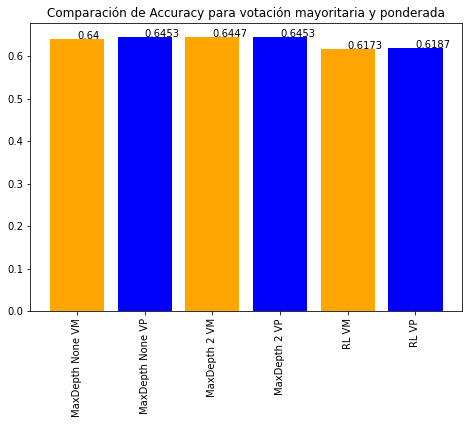

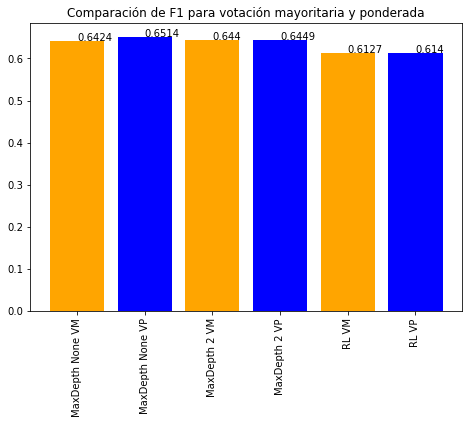

In [18]:
# Celda 9
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_title("Comparación de Accuracy para votación mayoritaria y ponderada")
ejeX = ['MaxDepth None VM','MaxDepth None VP','MaxDepth 2 VM','MaxDepth 2 VP','RL VM','RL VP']
ejeY = [round(metrics.accuracy_score(yPredmdNone, y_test),4),
       round(metrics.accuracy_score(yPredNone, y_test),4),
       round(metrics.accuracy_score(yPredmd2, y_test),4),
       round(metrics.accuracy_score(yPred2, y_test),4),
       round(metrics.accuracy_score(yPredmrl, y_test),4),
       round(metrics.accuracy_score(yPredrl, y_test),4)]

cc=['colors']*len(ejeX)
for n,val in enumerate(ejeX):
    if n%2:
        cc[n]='blue'
    else:
        cc[n]='orange'

ax.bar(ejeX,ejeY, color = cc)
def addlabels(x,y,plotP):
    for i in range(len(x)):
        plotP.text(i,y[i],y[i])
addlabels(ejeX,ejeY,plt)
plt.xticks(rotation=90)
plt.show()

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_title("Comparación de F1 para votación mayoritaria y ponderada")
ejeX = ['MaxDepth None VM','MaxDepth None VP','MaxDepth 2 VM','MaxDepth 2 VP','RL VM','RL VP']
ejeY = [round(metrics.f1_score(yPredmdNone, y_test),4),
       round(metrics.f1_score(yPredNone, y_test),4),
       round(metrics.f1_score(yPredmd2, y_test),4),
       round(metrics.f1_score(yPred2, y_test),4),
       round(metrics.f1_score(yPredmrl, y_test),4),
       round(metrics.f1_score(yPredrl, y_test),4)]
ax.bar(ejeX,ejeY, color = cc)
def addlabels(x,y,plotP):
    for i in range(len(x)):
        plotP.text(i,y[i],y[i])
addlabels(ejeX,ejeY,plt)
plt.xticks(rotation=90)
plt.show()

> #### Comparación de resultados 
> Los resultados obtenidos por ponderación mayoritaria y ponderada son muy similares entre los modelos pero se puede observar una ligera mejoría en la votación ponderada.

